In [ ]:
import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import os
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from conformer_opt import ConformerWithFreq  
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'Conformer' from 'conformer_opt' (c:\Users\USER\Desktop\RA\Conformer\conformer_optimized\conformer_opt.py)

In [ ]:
class EnhancedEEGProcessor:
    def __init__(self, base_path=None, data_ch_path=None, data_kr_path=None):
        """
        Инициализирует расширенный обработчик данных ЭЭГ.
        
        Args:
            base_path: Базовый путь к директории проекта
            data_ch_path: Путь к китайским данным
            data_kr_path: Путь к корейским данным
        """
        self.base_path = base_path 
        self.data_ch_path = data_ch_path or os.path.join(self.base_path, 'Data_ch')
        self.data_kr_path = data_kr_path or os.path.join(self.base_path, 'Data')
        
        # Настройка каналов ЭЭГ
        self.ch_ch = list(range(63))        # Каналы для китайского набора
        self.g_ch = list(range(61))         # Каналы для корейского набора
        
        # Каналы, которые нужно удалить
        self.ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]  # Для китайского набора
        self.g_rem = [46, 49, 56, 58, 59, 60]       # Для корейского набора
        
        # Удаляем указанные каналы
        for i in self.ch_rem:
            if i in self.ch_ch:
                self.ch_ch.remove(i)
        for j in self.g_rem:
            if j in self.g_ch:
                self.g_ch.remove(j)
        
        # Списки для хранения данных
        self.X_all = []
        self.y_all = []
        self.subjects_info = []  # Информация о субъектах
        self.fs = 100  # Частота дискретизации (Гц)
        
        # Настройки фильтров
        self.filter_settings = {
            'bandpass': {'low': 0.5, 'high': 45.0},  # Полосовой фильтр (Гц)
            'notch': 50.0,  # Режекторный фильтр (Гц)
            'order': 4      # Порядок фильтра
        }
        
        # Частотные диапазоны
        self.bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
        
    def load_chinese_data(self, condition="Ask", max_subjects=9, custom_path=None):
        """Загружает китайские данные."""
        print(f"Загрузка китайских данных ({condition})")
        
        for subj in range(1, max_subjects + 1):
            # Используем пользовательский путь, если указан
            if custom_path:
                file_path = f'{custom_path}/data_ch/{condition}/sbj_{subj}.mat'
            else:
                file_path = os.path.join(self.data_ch_path, f'{condition}/sbj_{subj}.mat')
                
            try:
                print(f"Загрузка файла: {file_path}")
                mat_data = loadmat(file_path)
                
                # Выбираем нужные каналы
                X = np.array(mat_data['x_post'])[:-1, self.ch_ch, :]
                y = np.array(mat_data['label_next_ind'])[0, :]
                
                # Транспонирование для получения формата (trials, channels, time)
                X = np.transpose(X)
                
                self.X_all.append(X)
                self.y_all.append(y)
                self.subjects_info.append(f"Chinese_{condition}_sbj_{subj}")
                
                print(f"  Форма данных X: {X.shape}, метки y: {y.shape}")
                
            except Exception as e:
                print(f"Ошибка при загрузке файла {file_path}: {e}")
    
    def load_korean_data(self, condition="Ask", max_subjects=14, custom_path=None):
        """Загружает корейские данные."""
        print(f"Загрузка корейских данных ({condition})")
        
        for subj in range(1, max_subjects + 1):
            # Используем пользовательский путь, если указан
            if custom_path:
                file_path = f'{custom_path}/data/{condition}/sbj_{subj}.mat'
            else:
                file_path = os.path.join(self.data_kr_path, f'{condition}/sbj_{subj}.mat')
                
            try:
                with h5py.File(file_path, 'r') as f:
                    print(f"Загрузка файла: {file_path}")
                    X = np.array(f['x_post'])[:, self.g_ch, :]
                    y = np.array(f['label_next_ind'])[:, 0]
                
                self.X_all.append(X)
                self.y_all.append(y)
                self.subjects_info.append(f"Korean_{condition}_sbj_{subj}")
                
                print(f"  Форма данных X: {X.shape}, метки y: {y.shape}")
                
            except Exception as e:
                print(f"Ошибка при загрузке файла {file_path}: {e}")
    
    def apply_bandpass_filter(self, data):
        """Применяет полосовой фильтр к данным ЭЭГ."""
        low = self.filter_settings['bandpass']['low']
        high = self.filter_settings['bandpass']['high']
        order = self.filter_settings['order']
        
        # Создаем фильтр Баттерворта
        b, a = signal.butter(order, [low/(self.fs/2), high/(self.fs/2)], btype='band')
        
        # Применяем фильтр ко всем каналам и испытаниям
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                filtered_data[i, j, :] = signal.filtfilt(b, a, data[i, j, :])
        
        return filtered_data
    
    def apply_notch_filter(self, data):
        """Применяет режекторный фильтр для удаления сетевых наводок."""
        notch_freq = self.filter_settings['notch']
        quality_factor = 30.0  # Добротность фильтра
        
        # Создаем режекторный фильтр
        b, a = signal.iirnotch(notch_freq, quality_factor, self.fs)
        
        # Применяем фильтр ко всем каналам и испытаниям
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                filtered_data[i, j, :] = signal.filtfilt(b, a, data[i, j, :])
        
        return filtered_data
    
    def extract_frequency_features(self, data):
        """Извлекает частотные признаки из данных ЭЭГ."""
        n_trials, n_channels, n_times = data.shape
        n_bands = len(self.bands)
        
        # Создаем массив для хранения признаков
        features = np.zeros((n_trials, n_channels * n_bands))
        
        # Вычисляем FFT для каждого испытания и канала
        for i in range(n_trials):
            for j in range(n_channels):
                # Вычисляем спектр мощности
                signal_fft = np.abs(np.fft.fft(data[i, j, :]))
                signal_fft = signal_fft[:n_times//2]
                
                # Вычисляем частоты
                freqs = np.fft.fftfreq(n_times, 1/self.fs)
                freqs = freqs[:n_times//2]
                
                # Вычисляем мощность в каждом частотном диапазоне
                for k, (band_name, (low, high)) in enumerate(self.bands.items()):
                    # Находим индексы для текущего диапазона частот
                    idx_band = np.logical_and(freqs >= low, freqs <= high)
                    
                    # Вычисляем среднюю мощность в диапазоне
                    if np.any(idx_band):
                        band_power = np.mean(signal_fft[idx_band])
                    else:
                        band_power = 0
                    
                    # Сохраняем признак
                    features[i, j * n_bands + k] = band_power
        
        return features
    
    def normalize_per_subject(self, data_list, scaler_type='robust'):
        """Нормализует данные по каждому субъекту отдельно."""
        normalized_data_list = []
        
        for i, data in enumerate(data_list):
            n_trials, n_channels, n_times = data.shape
            
            # Выбираем тип нормализации
            if scaler_type == 'robust':
                scaler = RobustScaler()
            else:
                scaler = StandardScaler()
            
            # Преобразуем данные для нормализации
            data_flat = data.reshape(n_trials, -1)
            
            # Нормализуем данные
            data_norm = scaler.fit_transform(data_flat)
            
            # Возвращаем исходную форму
            data_norm = data_norm.reshape(n_trials, n_channels, n_times)
            
            normalized_data_list.append(data_norm)
        
        return normalized_data_list
    
    def preprocess_data_no_leakage(self, use_freq_features=True, normalize_subjects=True, 
                                balance_method='smote', apply_filters=True, 
                                test_size=0.3, val_size=0.15):
        
        """Performs comprehensive EEG data preprocessing WITHOUT data leakage."""
        if not self.X_all:
            raise ValueError("Data not loaded. Call load_all_data() first.")
        
        # Step 1: Apply filters and normalization per subject (BEFORE any splitting)
        X_list = [X.copy() for X in self.X_all]
        y_list = [y.copy() for y in self.y_all]
        
        if apply_filters:
            print("Applying filters...")
            for i in range(len(X_list)):
                X_list[i] = self.apply_bandpass_filter(X_list[i])
                X_list[i] = self.apply_notch_filter(X_list[i])
        
        if normalize_subjects:
            print("Normalizing data per subject...")
            X_list = self.normalize_per_subject(X_list, scaler_type='robust')
        
        # Step 2: SUBJECT-LEVEL SPLIT (Critical fix)
        print("Performing subject-level train/val/test split...")
        n_subjects = len(X_list)
        subjects = list(range(n_subjects))
        
        # Split subjects, not trials
        n_test_subjects = max(1, int(n_subjects * test_size))
        n_val_subjects = max(1, int(n_subjects * val_size))
        n_train_subjects = n_subjects - n_test_subjects - n_val_subjects
        
        # Randomly assign subjects to sets
        np.random.seed(42)
        np.random.shuffle(subjects)
        
        train_subjects = subjects[:n_train_subjects]
        val_subjects = subjects[n_train_subjects:n_train_subjects + n_val_subjects]
        test_subjects = subjects[n_train_subjects + n_val_subjects:]
        
        print(f"Train subjects: {len(train_subjects)}, Val subjects: {len(val_subjects)}, Test subjects: {len(test_subjects)}")
        
        # Separate data by subject assignment
        X_train_list = [X_list[i] for i in train_subjects]
        y_train_list = [y_list[i] for i in train_subjects]
        
        X_val_list = [X_list[i] for i in val_subjects]
        y_val_list = [y_list[i] for i in val_subjects]
        
        X_test_list = [X_list[i] for i in test_subjects]
        y_test_list = [y_list[i] for i in test_subjects]
        
        # Concatenate within each set
        X_train = np.concatenate(X_train_list, axis=0)
        y_train = np.concatenate(y_train_list, axis=0)
        
        X_val = np.concatenate(X_val_list, axis=0)
        y_val = np.concatenate(y_val_list, axis=0)
        
        X_test = np.concatenate(X_test_list, axis=0)
        y_test = np.concatenate(y_test_list, axis=0)
        
        print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")
        print(f"Train classes: {np.bincount(y_train.astype(int))}")
        print(f"Val classes: {np.bincount(y_val.astype(int))}")
        print(f"Test classes: {np.bincount(y_test.astype(int))}")
        
        # Step 3: Feature extraction (per set to avoid leakage)
        if use_freq_features:
            print("Extracting frequency features...")
            train_freq_features = self.extract_frequency_features(X_train)
            val_freq_features = self.extract_frequency_features(X_val)
            test_freq_features = self.extract_frequency_features(X_test)
            
            X_train_features = np.hstack([X_train.reshape(X_train.shape[0], -1), train_freq_features])
            X_val_features = np.hstack([X_val.reshape(X_val.shape[0], -1), val_freq_features])
            X_test_features = np.hstack([X_test.reshape(X_test.shape[0], -1), test_freq_features])
        else:
            X_train_features = X_train.reshape(X_train.shape[0], -1)
            X_val_features = X_val.reshape(X_val.shape[0], -1)
            X_test_features = X_test.reshape(X_test.shape[0], -1)
        
        # Step 4: Apply SMOTE ONLY to training set (Critical fix)
        if balance_method == 'smote':
            print("Applying SMOTE to training set only...")
            sampler = SMOTE(random_state=42)
            X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_features, y_train)
            print(f"Training set after SMOTE: {X_train_balanced.shape}")
            print(f"Training classes after SMOTE: {np.bincount(y_train_balanced.astype(int))}")
        elif balance_method == 'undersample':
            print("Applying undersampling to training set only...")
            sampler = RandomUnderSampler(random_state=42)
            X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_features, y_train)
        else:
            X_train_balanced = X_train_features
            y_train_balanced = y_train
        
        # Validation and test sets remain unchanged
        X_val_final = X_val_features
        X_test_final = X_test_features
        
        # Restore 3D shape if not using frequency features
        if not use_freq_features:
            channels = X_train.shape[1]
            timesteps = X_train.shape[2]
            X_train_balanced = X_train_balanced.reshape(-1, channels, timesteps)
            X_val_final = X_val_final.reshape(-1, channels, timesteps)
            X_test_final = X_test_final.reshape(-1, channels, timesteps)
        
        return {
            'X_train': X_train_balanced,
            'y_train': y_train_balanced,
            'X_val': X_val_final,
            'y_val': y_val,
            'X_test': X_test_final,
            'y_test': y_test,
            'train_subjects': train_subjects,
            'val_subjects': val_subjects,
            'test_subjects': test_subjects
        }

In [ ]:
import os
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from conformer_opt import ConformerWithFreq

In [ ]:

# ...existing code for EnhancedEEGProcessor...

processor = EnhancedEEGProcessor(base_path='C:/Users/anurj/Desktop/RA-Fazli-BCI')

custom_path = 'C:/Users/anurj/Desktop/RA-Fazli-BCI'

processor.load_chinese_data(condition="Ask", custom_path=custom_path)
processor.load_korean_data(condition="Ask", custom_path=custom_path)

# 2) Preprocess raw EEG only—keep time‐series intact for Transformer
processed_raw = processor.preprocess_data_no_leakage(
    use_freq_features=False,    # ← keep shape (n_trials, n_ch, n_times)
    normalize_subjects=True,
    balance_method='undersample',  # ← changed from 'smote' to 'undersample'
    apply_filters=True,
    test_size=0.15,
    val_size=0.15,
)

X_train_raw = processed_raw['X_train']  # shape: (N_train, n_ch, n_times)
y_train     = processed_raw['y_train']
X_val_raw   = processed_raw['X_val']    # shape: (N_val, n_ch, n_times)
y_val       = processed_raw['y_val']
X_test_raw  = processed_raw['X_test']   # shape: (N_test, n_ch, n_times)
y_test      = processed_raw['y_test']

# 3) Separately compute per‐channel band‐power for each set
#    (n_bands = len(processor.bands) → 5 by default)



Загрузка китайских данных (Ask)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_1.mat
  Форма данных X: (996, 55, 100), метки y: (996,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_2.mat
  Форма данных X: (884, 55, 100), метки y: (884,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_3.mat
  Форма данных X: (1291, 55, 100), метки y: (1291,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_4.mat
  Форма данных X: (908, 55, 100), метки y: (908,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_5.mat
  Форма данных X: (882, 55, 100), метки y: (882,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_6.mat
  Форма данных X: (904, 55, 100), метки y: (904,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_7.mat
  Форма данных X: (942, 55, 100), метки y: (942,)
Загрузка файла: C:/Users/anurj/Desktop/RA-Fazli-BCI/data_ch/Ask/sbj_8.mat
  Форма данных X: (1453,

In [ ]:
def compute_freq_tensors(X_raw_np):
    """
    X_raw_np: NumPy array (n_trials, n_channels, n_times).
    Returns: Tensor of shape (n_trials, n_channels, n_bands).
    """
    # Use the same extract_frequency_features, then reshape:
    flat = processor.extract_frequency_features(X_raw_np)
    n_trials, flat_dim = flat.shape
    n_ch    = X_raw_np.shape[1]
    n_bands = flat_dim // n_ch
    freq_np = flat.reshape(n_trials, n_ch, n_bands)
    return torch.tensor(freq_np, dtype=torch.float32)

X_train_freq = compute_freq_tensors(X_train_raw)  # → (N_train, n_ch, n_bands)
X_val_freq   = compute_freq_tensors(X_val_raw)
X_test_freq  = compute_freq_tensors(X_test_raw)

# 4) Build PyTorch tensors for raw (time-domain)
X_train_raw_t = torch.tensor(X_train_raw, dtype=torch.float32).unsqueeze(1)  # (N_train, 1, n_ch, n_times)
X_val_raw_t   = torch.tensor(X_val_raw, dtype=torch.float32).unsqueeze(1)
X_test_raw_t  = torch.tensor(X_test_raw, dtype=torch.float32).unsqueeze(1)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# 5) Create a custom Dataset that returns (x_raw, x_freq, y)
class EEGTimeFreqDataset(Dataset):
    def __init__(self, X_raw, X_freq, y):
        self.X_raw  = X_raw
        self.X_freq = X_freq
        self.y      = y

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, idx):
        return self.X_raw[idx], self.X_freq[idx], self.y[idx]

train_dataset = EEGTimeFreqDataset(X_train_raw_t, X_train_freq, y_train_t)
val_dataset   = EEGTimeFreqDataset(X_val_raw_t,   X_val_freq,   y_val_t)
test_dataset  = EEGTimeFreqDataset(X_test_raw_t,  X_test_freq,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# 6) Initialize ConformerWithFreq
n_channels = X_train_raw.shape[1]       # e.g. 55
n_times    = X_train_raw.shape[2]       # e.g. 100
n_bands    = X_train_freq.shape[2]      # 5 by default

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConformerWithFreq(
    n_channels=n_channels,
    n_times=n_times,
    n_bands=n_bands,
    emb_size=40,
    depth=6,
    n_classes=2,
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# 7) Training loop
num_epochs = 100
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    for x_raw_batch, x_freq_batch, y_batch in train_loader:
        x_raw_batch  = x_raw_batch.to(device)   # (B, 1, n_ch, n_times)
        x_freq_batch = x_freq_batch.to(device)  # (B, n_ch, n_bands)
        y_batch      = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_raw_batch, x_freq_batch)  # (B, n_classes)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total   = 0
    with torch.no_grad():
        for x_raw_batch, x_freq_batch, y_batch in val_loader:
            x_raw_batch  = x_raw_batch.to(device)
            x_freq_batch = x_freq_batch.to(device)
            y_batch      = y_batch.to(device)

            val_logits = model(x_raw_batch, x_freq_batch)
            val_loss += criterion(val_logits, y_batch).item()

            preds = val_logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total   += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_conformer_with_freq.pt")

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# 8) Test
model.load_state_dict(torch.load("best_conformer_with_freq.pt"))
model.eval()

all_preds  = []
all_labels = []
with torch.no_grad():
    for x_raw_batch, x_freq_batch, y_batch in test_loader:
        x_raw_batch  = x_raw_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch      = y_batch.to(device)

        out_logits = model(x_raw_batch, x_freq_batch)
        preds = out_logits.argmax(dim=1).cpu().numpy()
        labels = y_batch.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

Epoch 01 | Train Loss: 0.6981 | Val Loss: 0.7088 | Val Acc: 0.3768
Epoch 02 | Train Loss: 0.6939 | Val Loss: 0.6788 | Val Acc: 0.6246
Epoch 03 | Train Loss: 0.6925 | Val Loss: 0.6985 | Val Acc: 0.4564
Epoch 04 | Train Loss: 0.6918 | Val Loss: 0.6967 | Val Acc: 0.4680
Epoch 05 | Train Loss: 0.6902 | Val Loss: 0.6898 | Val Acc: 0.5080
Epoch 06 | Train Loss: 0.6894 | Val Loss: 0.6969 | Val Acc: 0.4784
Epoch 07 | Train Loss: 0.6895 | Val Loss: 0.7095 | Val Acc: 0.4534
Epoch 08 | Train Loss: 0.6889 | Val Loss: 0.6963 | Val Acc: 0.4807
Epoch 09 | Train Loss: 0.6894 | Val Loss: 0.6992 | Val Acc: 0.4701
Epoch 10 | Train Loss: 0.6891 | Val Loss: 0.7010 | Val Acc: 0.4673
Epoch 11 | Train Loss: 0.6883 | Val Loss: 0.7035 | Val Acc: 0.4650
Epoch 12 | Train Loss: 0.6886 | Val Loss: 0.7015 | Val Acc: 0.4657
Epoch 13 | Train Loss: 0.6879 | Val Loss: 0.7056 | Val Acc: 0.4586
Epoch 14 | Train Loss: 0.6882 | Val Loss: 0.6991 | Val Acc: 0.4739
Epoch 15 | Train Loss: 0.6886 | Val Loss: 0.6966 | Val Acc: 0.

F1 Score: 0.5202453879451738


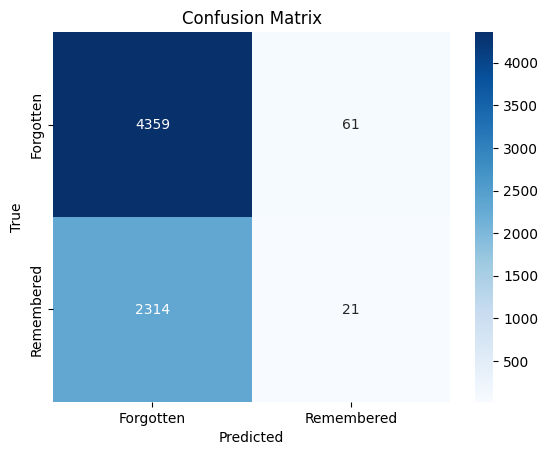

In [ ]:
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(all_labels, all_preds, average='weighted'))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forgotten', 'Remembered'],
            yticklabels=['Forgotten', 'Remembered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()